In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import json
import sys

from thorr.utils import read_config, Logger, validate_start_end_dates
from thorr.database import Connect as db_connect


# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

# from sklearn.model_selection import KFold, ShuffleSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression

from joblib import dump, load

In [2]:
config_file = Path('/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/03-HAB/.env/hab_config.ini')

config_dict = read_config(config_file)
project_dir = Path(config_dict["project"]["project_dir"])

In [3]:
hls_insitu = pd.read_csv(project_dir / "data/hls_insitu/hls_insitu_chl_a_clean.csv", low_memory=False)

In [4]:
hls_insitu_bnd_algo = hls_insitu[
    [
        "ID",
        "Date",
        "ReachID",
        "b01_median",
        "b02_median",
        "b03_median",
        "mbr_median",
        "mbr_mean",
        "oc3_chl_median",
        "ci_median",
        "StationID",
        "chl_a",
        "mbr_v2",
        "mission"
    ]
]
hls_insitu_bnd_algo.to_csv("hls_insitu_bnd_algo.csv", index=False)

# Aggregate by ReachID, Date and StationID
hls_insitu_bnd_algo_grouped_daily = hls_insitu_bnd_algo.drop(columns=["ID", "mission"]).groupby(['ReachID', 'Date', 'StationID'], as_index=False).mean()
hls_insitu_bnd_algo_grouped_daily.to_csv("hls_insitu_bnd_algo_grouped_daily.csv", index=False)

In [5]:
hls_insitu_bnd_algo_grouped_daily = pd.read_csv("hls_insitu_bnd_algo_grouped_daily.csv", low_memory=False)

## Ocean Color Algorithm

In [6]:
def calc_oc3(mbr):
    """Calculate OC3 chlorophyll using band ratio.

    Args:
        mbr (pd.Series): Band ratio (max of band 1 and band 2 divided by band 3).

    Returns:
        pd.Series: Calculated chlorophyll concentration.
    """
    a0, a1, a2, a3, a4 = 0.30963, -2.40052, 1.28932, 0.52802, -1.33825

    log_chl = (
        a0
        + a1 * np.log10(mbr)
        + a2 * (np.log10(mbr) ** 2)
        + a3 * (np.log10(mbr) ** 3)
        + a4 * (np.log10(mbr) ** 4)
    )
    chl = 10 ** log_chl
    return chl

hls_insitu_bnd_algo_grouped_daily['oc3_chl_new'] = calc_oc3(hls_insitu_bnd_algo_grouped_daily['mbr_median'])

/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-THORR/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


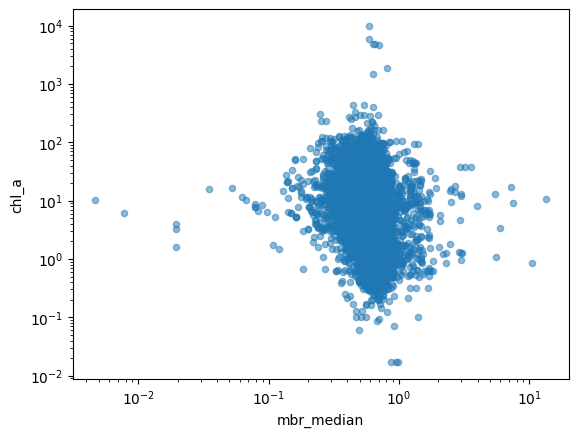

In [7]:
fig, ax = plt.subplots()
hls_insitu_bnd_algo_grouped_daily.plot.scatter(x="mbr_median", 
                                               y="chl_a", 
                                               ax=ax, 
                                               alpha=0.5,)

ax.set(yscale="log", 
       xscale="log");

In [8]:
# fit line to data (using simple linear regression on log-log data)
fit_xy = hls_insitu_bnd_algo_grouped_daily[['mbr_median', 'chl_a']].dropna()
fit_xy = fit_xy[(fit_xy['mbr_median'] > 0) & (fit_xy['chl_a'] > 0)].copy()
fit_xy['log_mbr'] = np.log10(fit_xy['mbr_median'])
fit_xy['log_chl_a'] = np.log10(fit_xy['chl_a'])
lr_X = fit_xy['log_mbr'].values
lr_y = fit_xy['log_chl_a'].values
lr_model = LinearRegression()
lr_model.fit(lr_X.reshape(-1, 1), lr_y)

print(f"Linear Regression:\n y = {lr_model.coef_[0]:.4f}x + {lr_model.intercept_:.4f}")


Linear Regression:
 y = -0.8003x + 0.6869


In [9]:
# Inverse linear regression model
lr_inv_model = LinearRegression()
lr_inv_model.fit(lr_y.reshape(-1, 1), lr_X)
print(f"Inverse Linear Regression:\n x = {lr_inv_model.coef_[0]:.4f}y + {lr_inv_model.intercept_:.4f}")
print(f"Inverse Linear Regression (rearranged):\n y = {(1/lr_inv_model.coef_[0]):.4f}x + {(-lr_inv_model.intercept_/lr_inv_model.coef_[0]):.4f}")

# define custom lr_inv_model function
def lr_inv_model_func(mbr):
    return (1/lr_inv_model.coef_[0]) * mbr + (-lr_inv_model.intercept_/lr_inv_model.coef_[0])

Inverse Linear Regression:
 x = -0.0535y + -0.1895
Inverse Linear Regression (rearranged):
 y = -18.6929x + -3.5416


In [10]:
pf_4_coeffs = np.polyfit(lr_X, lr_y, 4)
pf_4 = np.poly1d(pf_4_coeffs)
print("4th Degree Polynomial Coefficients:")
for i, coeff in enumerate(pf_4_coeffs):
    print(f"  Coefficient of x^{4 - i}: {coeff:.6f}")
# def pf_4_model_func(mbr):
#     log_mbr = np.log10(mbr)
#     log_chl = (
#         pf_4_coeffs[0] * (log_mbr ** 4)
#         + pf_4_coeffs[1] * (log_mbr ** 3)
#         + pf_4_coeffs[2] * (log_mbr ** 2)
#         + pf_4_coeffs[3] * log_mbr
#         + pf_4_coeffs[4]
#     )
#     chl = 10 ** log_chl
#     return chl

4th Degree Polynomial Coefficients:
  Coefficient of x^4: 0.441510
  Coefficient of x^3: 1.313651
  Coefficient of x^2: 0.209389
  Coefficient of x^1: -1.212087
  Coefficient of x^0: 0.604745


In [11]:
from sklearn.metrics import r2_score
r2_df = hls_insitu_bnd_algo_grouped_daily[['oc3_chl_new', 'chl_a', 'mbr_median']].dropna()
r2_df = r2_df[(r2_df['mbr_median'] > 0) & (r2_df['chl_a'] > 0)].copy()

r2_df['log_oc3_chl'] = np.log10(r2_df['oc3_chl_new'])
r2_df['log_chl_a'] = np.log10(r2_df['chl_a'])
r2_df['log_mbr'] = np.log10(r2_df['mbr_median'])

r2_df['lr_predicted_chl'] = lr_model.predict(r2_df['log_mbr'].values.reshape(-1,1))
r2_df['lr_inv_predicted_chl'] = lr_inv_model_func(r2_df['log_mbr'].values.reshape(-1,1))
r2_value = r2_score(r2_df['log_chl_a'], r2_df['log_oc3_chl'])
print(f"R² value for OC3: {r2_value:.4f}")
r2_lr = r2_score(r2_df['log_chl_a'], r2_df['lr_predicted_chl'])
print(f"R² value for Linear Regression: {r2_lr:.4f}")
r2_inv_lr = r2_score(r2_df['log_chl_a'], r2_df['lr_inv_predicted_chl'])
print(f"R² value for Inverse Linear Regression: {r2_inv_lr:.4f}")
r2_pf4 = r2_score(r2_df['log_chl_a'], pf_4(r2_df['log_mbr'].values.reshape(-1,1)))
print(f"R² value for 4th Degree Polynomial: {r2_pf4:.4f}")

R² value for OC3: -0.7909
R² value for Linear Regression: 0.0428
R² value for Inverse Linear Regression: -21.3560
R² value for 4th Degree Polynomial: 0.0569


/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-THORR/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Pearson correlation coefficient: 0.00


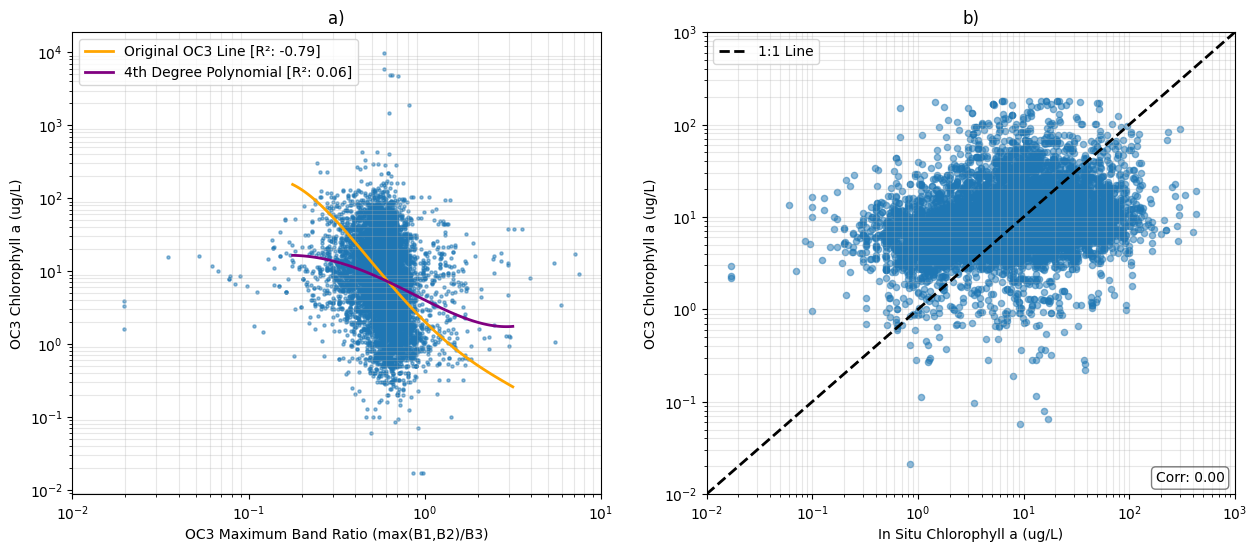

In [45]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(15,6))

ax.grid(True, which="both", alpha=0.3)
hls_insitu_bnd_algo_grouped_daily.plot.scatter(x="mbr_median", 
                                               y="chl_a", 
                                               ax=ax,
                                               s=5 ,
                                               alpha=0.5,)
ax.set(yscale="log", 
       xscale="log");

# add OC3 line
x = np.logspace(-.75, .5, 100)
Y = np.logspace(-1, 3, 100)
oc3_y = calc_oc3(x)
ax.plot(x, oc3_y, color='orange', label=f'Original OC3 Line [R²: {r2_value:.2f}]', linewidth=2)
# add linear regression line
lr_y_pred = lr_model.predict(np.log10(x).reshape(-1, 1))
# ax.plot(x, 10**lr_y_pred, color='blue', label=f'Linear Regression Line\ny = {lr_model.coef_[0]:.4f}x + {lr_model.intercept_:.4f}', linewidth=2)

# add inverse linear regression line
# inv_lr_y = lr_inv_model_func(np.log10(x).reshape(-1, 1))
# plt.plot(x, inv_lr_y, color='orange', label='Inverse Linear Regression Line', linewidth=2)
lr_inv_x = lr_inv_model.predict(np.log10(Y).reshape(-1, 1))
lr_inv_y = lr_inv_model_func(np.log10(x).reshape(-1, 1))
# ax.plot(x, 10**lr_inv_y, color='red', label='Inverse Linear Regression Line', linewidth=2)
pf_4_y = pf_4(np.log10(x))
# ax.plot(10**lr_inv_x, Y, color='orange', label='Inverse Linear Regression Line', linewidth=2)
ax.plot(x, 10**pf_4_y, color='purple', label=f'4th Degree Polynomial [R²: {r2_pf4:.2f}]', linewidth=2)

ax.set_xlim(0.01, 10)
ax.legend()
ax.set_xlabel('OC3 Maximum Band Ratio (max(B1,B2)/B3)')
ax.set_ylabel('OC3 Chlorophyll a (ug/L)')
# ax1.set_xlabel('OC3 Calculated Chlorophyll a (ug/L)')


hls_insitu_bnd_algo_grouped_daily['oc3_chl_new'] = calc_oc3(hls_insitu_bnd_algo_grouped_daily['mbr_median'])
# hls_insitu_bnd_algo_grouped_daily['oc3_chl_new'] = 10**pf_4(np.log10(hls_insitu_bnd_algo_grouped_daily['mbr_median']))

hls_insitu_bnd_algo_grouped_daily.plot.scatter(x="chl_a", 
                                               y="oc3_chl_new", 
                                               ax=ax1, 
                                               alpha=0.5,)
# calculate pearson correlation coefficient
pearson_corr = hls_insitu_bnd_algo_grouped_daily[[ 'oc3_chl_new', 'chl_a',]].corr(method='pearson').iloc[0,1]
print(f"Pearson correlation coefficient: {pearson_corr:.2f}")

ax1.set(yscale="log", 
       xscale="log");

ax1.grid(True, which="both", alpha=0.3)
ax1.set_ylabel('OC3 Chlorophyll a (ug/L)')
ax1.set_xlabel('In Situ Chlorophyll a (ug/L)')
ax1.text(0.85, 0.05, f'Corr: {pearson_corr:.2f}', 
         transform=ax1.transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))  
# add 1:1 line
x = np.logspace(-2, 3, 100)
y = x
ax1.plot(x, y, color='k', label='1:1 Line', linewidth=2, linestyle='--')
ax1.set_xlim(0.01, 1000)
ax1.set_ylim(0.01, 1000)
ax1.legend()
ax.set_title("a)")
ax1.set_title("b)")
fig.savefig("oc3_ci_comparison.png", dpi=300, bbox_inches='tight')

In [46]:
pearson_corr

np.float64(0.004545433530626649)

/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/01-THORR/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(0.01, 10000)

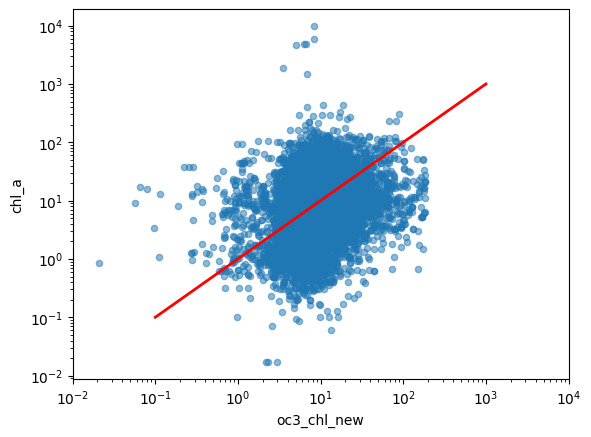

In [19]:
fig, ax = plt.subplots()
hls_insitu_bnd_algo_grouped_daily['oc3_chl_new'] = calc_oc3(hls_insitu_bnd_algo_grouped_daily['mbr_median'])
hls_insitu_bnd_algo_grouped_daily.plot.scatter(x="oc3_chl_new", 
                                               y="chl_a", 
                                               ax=ax, 
                                               alpha=0.5,)
ax.set(yscale="log", 
       xscale="log");
# add 1:1 line
x = np.logspace(-1, 3, 100)
y = x
ax.plot(x, y, color='red', label='1:1 Line', linewidth=2)
ax.set_xlim(0.01, 10000)

## Color Index Algorith

In [6]:
hls_insitu_bnd_algo_grouped_daily.columns,

(Index(['ReachID', 'Date', 'StationID', 'b01_median', 'b02_median',
        'b03_median', 'mbr_median', 'mbr_mean', 'oc3_chl_median', 'ci_median',
        'chl_a', 'mbr_v2'],
       dtype='object'),)

In [64]:
ci_lr = LinearRegression()
fit_xy_ci = hls_insitu_bnd_algo_grouped_daily[hls_insitu_bnd_algo_grouped_daily['ci_median']<-0.0005][['ci_median', 'chl_a']].dropna()
fit_xy_ci = fit_xy_ci[(fit_xy_ci['chl_a'] > 0) & (fit_xy_ci['ci_median'] < -0.0005)].copy()
fit_xy_ci['log_chl'] = np.log10(fit_xy_ci['chl_a'])
lr_X_ci = fit_xy_ci['ci_median'].values
lr_y_ci = fit_xy_ci['log_chl'].values
ci_lr.fit(lr_X_ci.reshape(-1, 1), lr_y_ci)

print(f"CI Linear Regression:\n y = {ci_lr.coef_[0]:.4f}x + {ci_lr.intercept_:.4f}")

CI Linear Regression:
 y = -1.2727x + 0.6672


In [90]:
# Calculate R² for CI model
r2_ci_df = hls_insitu_bnd_algo_grouped_daily[hls_insitu_bnd_algo_grouped_daily['ci_median']<-0.0005][['ci_median', 'chl_a']].dropna()
r2_ci_df = r2_ci_df[r2_ci_df['chl_a'] > 0].copy()
r2_ci_df['log_chl'] = np.log10(r2_ci_df['chl_a'])
r2_ci_df['ci_lr_predicted_log_chl'] = ci_lr.predict(r2_ci_df['ci_median'].values.reshape(-1,1))
r2_ci_value = r2_score(r2_ci_df['log_chl'], r2_ci_df['ci_lr_predicted_log_chl'])
print(f"R² value for CI Linear Regression: {r2_ci_value:.4f}")

R² value for CI Linear Regression: 0.0027


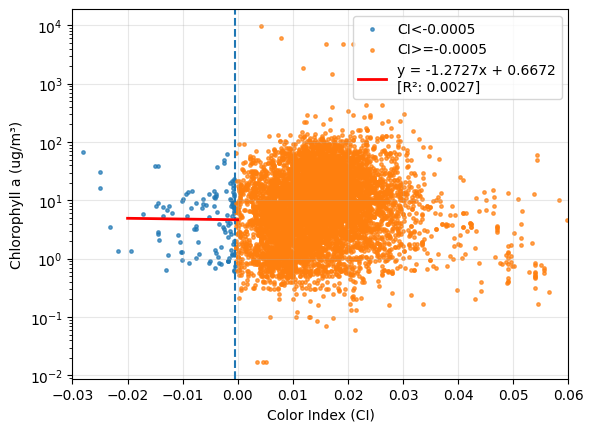

In [93]:
fig, ax = plt.subplots()

ax.scatter(
    hls_insitu_bnd_algo_grouped_daily[hls_insitu_bnd_algo_grouped_daily['ci_median']<-0.0005]['ci_median'],
    hls_insitu_bnd_algo_grouped_daily[hls_insitu_bnd_algo_grouped_daily['ci_median']<-0.0005]['chl_a'],
    alpha=0.7,
    # marker='x',
    s=6,
    label='CI<-0.0005'
)
ax.scatter(
    hls_insitu_bnd_algo_grouped_daily[hls_insitu_bnd_algo_grouped_daily['ci_median']>=-.0005]['ci_median'],
    hls_insitu_bnd_algo_grouped_daily[hls_insitu_bnd_algo_grouped_daily['ci_median']>=-0.0005]['chl_a'],
    alpha=0.7,
    # marker='x',
    s=6,
    label='CI>=-0.0005'
)
ax.axvline(x=-0.0005, linestyle='--')

ci_x = np.linspace(-0.02, 0.0, 10)
ci_y = ci_lr.predict(ci_x.reshape(-1, 1))
# ax.plot(ci_x, 10**ci_y, color='red', label=f'CI Linear Regression Line\ny = {ci_lr.coef_[0]:.4f}x + {ci_lr.intercept_:.4f}\n[R²: {r2_ci_value:.4f}]', linewidth=2)
ax.plot(ci_x, 10**ci_y, color='red', label=f'y = {ci_lr.coef_[0]:.4f}x + {ci_lr.intercept_:.4f}\n[R²: {r2_ci_value:.4f}]', linewidth=2)

ax.set_yscale("log")
ax.set_xlim(-0.03, .06)
ax.legend()
ax.set_xlabel('Color Index (CI)')
ax.set_ylabel('Chlorophyll a (ug/m³)')
ax.legend(loc='upper right')
ax.grid(alpha=0.3)

fig.savefig('ci_plot.png', dpi=300)